In [2]:
#importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from openTSNE import TSNE
from scipy.ndimage import convolve
from scipy.stats import gaussian_kde
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.utils import plot_model, to_categorical

# **Analysis of Machine Learning Models and Statistical Methods on MNIST Data**

Author: Kyra Cho

**Outline of Contents:**
- The Tools and Libraries Utilized for Statistical Analysis, Visualization, and Machine Learning
- Introducing the MNIST Dataset
- Data visualization and exploratory data analysis:
    - The Histogram of Pixel Intensities
    - The t-Distributed Stochastic Neighbor Embedding (t-SNE)
    - The Distribution of Digits
    - The Average Digits Visualization
- The classification models:
    - The Random Forests model
    - The Multinomial Logistic Regression model
    - The Dense Neural Network model
    - The Convolutional Neural Network (CNN) model
    - The Resnet Neural Network (RNN) model
    - Model Comparison
<br>
### **The Tools and Libraries Utilized for Statistical Analysis, Visualization, and Machine Learning**
- **Seaborn , Matplotlib:** The tool used for visualizing throughout this exercise is Seaborn. Seaborn relies on Matplotlib for the underlying plotting functionality, making Matplotlib a required dependency for Seaborn to work. Generally, it's an attractive visualization tool for statistical analysis. 

- **Tensorflow:** TensorFlow is an open-source machine learning framework developed by Google, designed for high-performance numerical computation and large-scale machine learning. Keras, which is integrated into TensorFlow, is a high-level neural networks API that allows for easy and fast prototyping, experimentation, and deployment of deep learning models. Together, they provide a great environment for developing, training, and deploying machine learning models.

- **Various statistical tools:**
    - Bar plot
    - Classification reports
    - Confusion matrices
    - Histogram
    - Machine learning algorithms
    - t-SNE plot

### **Introducing the MNIST Dataset**
The MNIST dataset, short for Modified National Institute of Standards and Technology dataset, is a large collection of handwritten digits. The dataset consists of 70,000 grayscale images, each of size 28x28 pixels, resulting in 784 features per image. There are 256 possible values per feature, each value corresponding to a color intensity. 0 is black, 255 is white, and values between represent varying shades of grey. The dataset is divided into a training set of 60,000 images and a test set of 10,000 images. Each image in the MNIST dataset represents a handwritten digit ranging from 0 to 9, labeled accordingly.


### **Histogram of Pixel Intensities**

The following histogram of pixel intensities shows the distribution of the grayscale values (ranging from 0 to 255) across all pixels in the dataset.

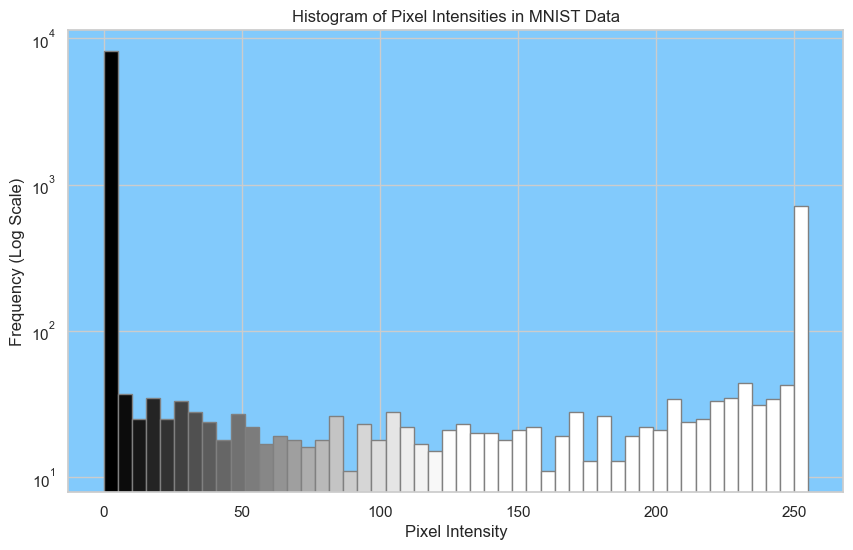

In [113]:
# Load data
with np.load("mnist.npz", allow_pickle=True) as f:
    train_x, train_y = f["x_train"], f["y_train"]

# Flatten the arrays
pixels = train_x.reshape(-1)

# Assuming 'pixels' is defined
sample_size = 10000
sampled_pixels = np.random.choice(pixels, size=sample_size, replace=False)

# Create a gradient color palette
cmap = plt.get_cmap("Greys_r")

# Plot the histogram using Seaborn
plt.figure(figsize=(10, 6))
hist_data = sns.histplot(sampled_pixels, bins=50, color='blue', alpha=0.75, edgecolor='grey')

# Normalize the bin centers for color mapping
bin_centers = 0.5 * (hist_data.patches[0].xy[0] + hist_data.patches[-1].xy[0])
normalized_bin_centers = np.array([patch.xy[0] for patch in hist_data.patches]) / bin_centers

# Set color of each patch based on normalized bin centers
for center, patch in zip(normalized_bin_centers, hist_data.patches):
    patch.set_facecolor(cmap(center))

# Set the background color to grey
plt.gca().set_facecolor('tan')
plt.gca().patch.set_facecolor('xkcd:sky')

# Set the y-axis to log scale
plt.yscale('log')
plt.title('Histogram of Pixel Intensities in MNIST Data')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency (Log Scale)')
plt.show()

***Figure 1: Histogram of pixel intensities in NMIST data.***

**Analysis of Figure 1:** The histogram indicates that the pixel values 0 and 255 are the most common. This is consistent with the fact that most of the MNIST images have a black or very dark background. Since the images are grayscale, the background pixels will have intensity values close to 0. This leads to a large number of pixels with very low intensity values. On ther other hand, the strokes that form the digits are white. Therefore, these pixels have intensity values close to 255. The over-representation of the darkest and lightest colors in MNIST data reflects the nature of the images: high contrast between the digit strokes and the background, which is beneficial for digit classification.

### **t-Distributed Stochastic Neighbor Embedding (t-SNE)**

Although each image in the MNIST dataset represents a single digit, each image has a high number of features per image $(28 \times 28 = 784)$. The t-distributed stochastic neighbor embedding (t-SNE) algorithm visualizes a sample from the MNIST dataset in a two dimensional plot. 

The algorithm converts high-dimensional Euclidean distances between data points into conditional probabilities representing similarities. The algorithm comprises two main stages. First, t-SNE constructs a probability distribution over pairs of high-dimensional objects in such a way that similar objects are assigned a higher probability while dissimilar points are assigned a lower probability. Second, t-SNE defines a similar probability distribution over the points in the low-dimensional map, and it minimizes the Kullback–Leibler divergence (KL divergence) between the two distributions with respect to the locations of the points in the map.

For two points $x_i$ and $x_j$, the similarity is modeled by a Gaussian distribution:
$$p_{j|i} = \frac{\exp\left(-\frac{\| x_i - x_j \|^2}{2\sigma_i^2}\right)}{\sum_{k \neq i} \exp\left(-\frac{\| x_i - x_k \|^2}{2\sigma_i^2}\right)}$$
and symmetrised as
$$p_{ij} = \frac{p_{j|i} + p_{i|j}}{2N}$$
where $\sigma_i$ is the bandwidth of the Gaussian kernel for point $x_i$ and $N$ is the number of data points. In the low-dimensional space, t-SNE aims to maintain these similarities using a Student's t-distribution with one degree of freedom (which has heavier tails than a Gaussian). The similarity between two points $y_i$ and $y_j$ in the low-dimensional space is given by:
$$q_{ij} = \frac{\left(1 + \| y_i - y_j \|^2\right)^{-1}}{\sum_{k \neq l} \left(1 + \| y_k - y_l \|^2\right)^{-1}}$$
The locations of the low-dimensional points $y_i$ are then found by minimizing the Kullback-Leibler divergence between the joint probabilities $p_{ij}$ and $q_{ij}$:
$$C = \sum_{i \neq j} p_{ij} \log \frac{p_{ij}}{q_{ij}}.$$
This objective is minimized using gradient descent to reveal a meaningful 2D representation of the high-dimensional data.

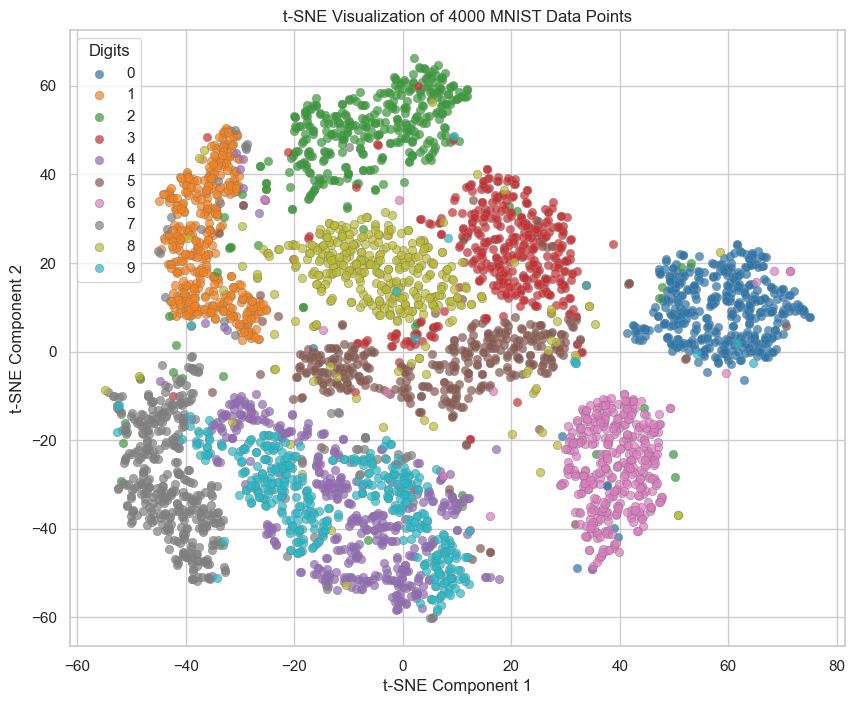

In [114]:
with np.load("mnist.npz", allow_pickle=True) as f:
    train_x, train_y = f["x_train"], f["y_train"]
    test_x, test_y = f["x_test"], f["y_test"]
    
# Flatten the images (from 28x28 to 784x1)
train_x = train_x.reshape(train_x.shape[0], -1)
test_x = test_x.reshape(test_x.shape[0], -1)

# Set the seed for reproducibility
np.random.seed(42)

# Sample 4000 data points randomly from MNIST
sample_size = 4000
indices = np.random.choice(train_x.shape[0], size=sample_size, replace=False)
X_sample = train_x[indices]
y_sample = train_y[indices]

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_sample)


plt.figure(figsize=(10, 8))

# Create a color palette
palette = sns.color_palette("tab10", 10)

# Plot each class with a different color
for i in range(10):
    sns.scatterplot(
        x=X_tsne[y_sample == i, 0], 
        y=X_tsne[y_sample == i, 1], 
        color=palette[i], 
        label=str(i), 
        alpha=0.7, 
        edgecolor='grey', 
        linewidth=0.5
    )
plt.title('t-SNE Visualization of {} MNIST Data Points'.format(sample_size))
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title="Digits")
plt.show()

***Figure 2: t-SNE visualization of 4000 MNIST data points***

**Analysis of Figure 2:** In the t-SNE plot of 4000 MNIST data points, we see clusters of points that correspond to different digit classes (0-9). Each cluster represents a distinct digit, with points in the same cluster sharing similar characteristics. The t-SNE algorithm reduces the high-dimensional data to a two-dimensional space while preserving local structures, so points that are close in the high-dimensional space are also be close in the 2D plot. The plot has different colors for each digit, as indicated by the legend, making it easier to visually distinguish between the different clusters. There are some overlap or mixing between clusters, particularly for digits that are visually similar, such as '4' and '9', as well as '3', '5', and '8'. But overall, the t-SNE plot reveals clear groupings corresponding to the individual digits. For a data set with $n$ elements, t-SNE runs in $O(n^2)$ time and requires $O(n^2)$ space.

### **Distribution of Digits**

The distribution of digits bar graph provides a quick visual summary of the dataset and identifies any class imbalance by showing the frequency of each digit class.

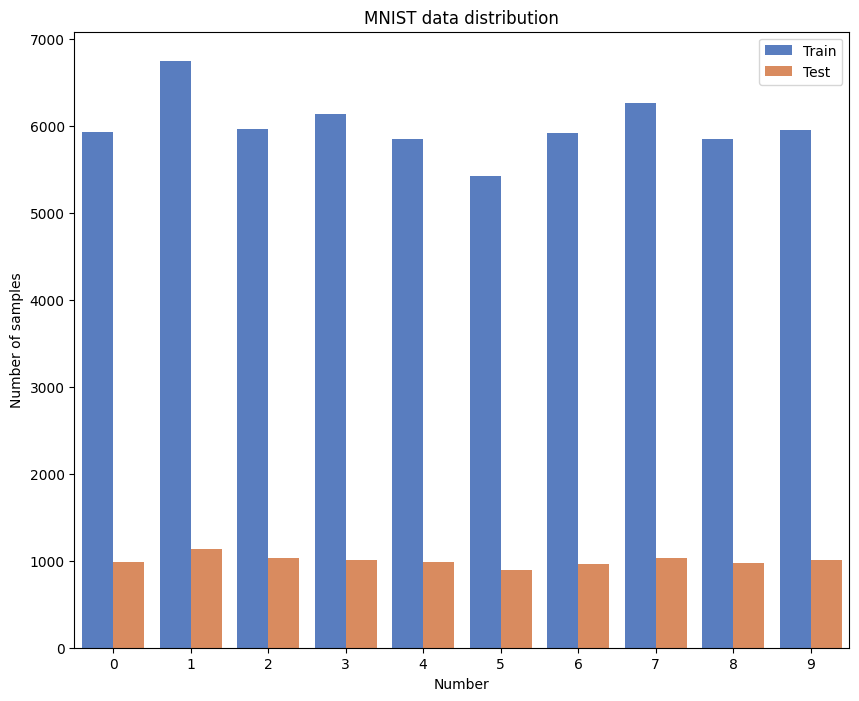

In [7]:
# Count number of samples for each class and plotting them
(_, train_count) = np.unique(train_y, return_counts=True)
(_, test_count) = np.unique(test_y, return_counts=True)

plt.figure(figsize=(10, 8))
plt.title('MNIST data distribution')
plt.xticks(range(10), labels=range(10))
plt.xlabel('Number')
plt.ylabel('Number of samples')

# Create a DataFrame for Seaborn
data = {'Number': np.tile(range(10), 2),
        'Count': np.concatenate([train_count, test_count]),
        'Dataset': ['Train'] * 10 + ['Test'] * 10}

# Plot with Seaborn
sns.barplot(x='Number', y='Count', hue='Dataset', data=data, palette='muted')
plt.legend()
plt.savefig('DataDistribution.png')
plt.show()

***Figure 3: MNIST data distribution***

**Analysis of Figure 3:** The bar plot visualizes the distribution of each digit in the training set. Ideally, the heights of the bars should be similar, indicating a balanced dataset. The plot shows differences in the counts of digits in the training set, indicating class imbalance. A balanced dataset is crucial for training machine learning models to ensure that the model does not become biased towards more frequently occurring classes. However, MNIST has a high level of redundancy, and its data are rich in features, making class imbalance a minor concern.

## **Average Digits**

The average digits analysis of the MNIST classes involves computing the average pixel values for each digit class (0 through 9) to generate a composite image representing the "average" appearance of each digit.

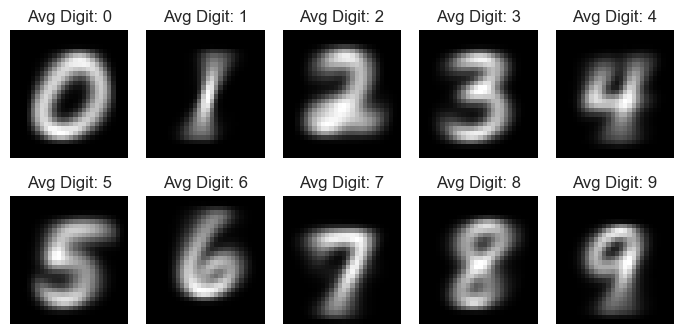

In [97]:
# Create a figure with 2 rows and 5 columns of subplots
fig, axes = plt.subplots(2, 5, figsize=(7, 3.5))

# Loop over each digit from 0 to 9
for i in range(10):
    # Determine the current subplot based on the digit
    ax = axes[i // 5, i % 5]
    
    # Calculate the average image for the current digit
    avg_image = train_x[train_y == i].mean(axis=0).reshape(28, 28)
    
    # Plot the average image using a heatmap
    sns.heatmap(avg_image, cmap='gray', ax=ax, cbar=False)
    
    # Set the title of the subplot to indicate the digit
    ax.set_title(f'Avg Digit: {i}')
    
    # Turn off the axis labels
    ax.axis('off')

# Adjust the layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

***Figure 4: Average digits***

**Analysis of Figure 4:** This visualization provides the averages of the images, so distinctive features that are common across many instances of a digit can be highlighted, while noise and individual variations are smoothed out. This can be useful for identifying the most salient features of each digit. It is also useful for assessing the quality and consistency of the dataset. Significant deviations in the average image might indicate issues with data labeling or preprocessing. The white areas are crucial for classification and grey areas pose learning challenges.

In [46]:
'''# Functions to be used for analyzing the classification models
def plot_history(history, filename, model_name):
  best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))
  fig, ax1 = plt.subplots(figsize=(8,6))
  plt.title(' '.join([model_name, 'model learning curve - Max accuracy on test is %1.4f' % max(history.history['val_accuracy'])]))
  ax1.set_xlabel('Epochs')
  ax1.set_xticks(range(Epochs))
  ax1.set_ylabel('Loss')
  ax1.plot(range(Epochs), history.history['loss'], 'r', label='Train Loss')
  ax1.plot(range(Epochs), history.history['val_loss'], 'orange', label='Test Loss')
  ax1.axvline(best_epoch, color='m', lw=4, alpha=0.5, label='Best epoch')
  ax1.legend()
  ax2 = ax1.twinx()
  ax2.set_ylabel('Accuracy')
  ax2.plot(range(Epochs), history.history['accuracy'], 'g', label='Train Accuracy')
  ax2.plot(range(Epochs), history.history['val_accuracy'], 'b', label='Test Accuracy')
  ax2.legend()
  plt.savefig(filename)
  plt.show()'''

# Define the function to plot the training history using Seaborn
def plot_history(history, filename, model_name, epochs):
    best_epoch = history.history['val_loss'].index(min(history.history['val_loss']))
    fig, ax1 = plt.subplots(figsize=(10, 7))
    
    plt.title(f'{model_name} model learning curve - Max accuracy on test is {max(history.history["val_accuracy"]):.4f}')
    
    ax1.set_xlabel('Epochs')
    ax1.set_xticks(range(epochs))
    ax1.set_ylabel('Loss')
    
    sns.lineplot(x=range(epochs), y=history.history['loss'], ax=ax1, color='r', label='Train Loss')
    sns.lineplot(x=range(epochs), y=history.history['val_loss'], ax=ax1, color='orange', label='Test Loss')
    ax1.axvline(best_epoch, color='m', lw=2, alpha=0.5, label='Best epoch')
    ax1.legend(loc='upper left')
    
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy')
    
    sns.lineplot(x=range(epochs), y=history.history['accuracy'], ax=ax2, color='g', label='Train Accuracy')
    sns.lineplot(x=range(epochs), y=history.history['val_accuracy'], ax=ax2, color='b', label='Test Accuracy')
    ax2.legend(loc='upper right')
    
    plt.savefig(filename)
    plt.show()
    
'''
def plot_first25labels(test_x, test_y, test_y_hat):
    #plotting first 25 samples with labels
    plt.figure(figsize=(7,7))
    plt.suptitle('First 25 samples of MNIST test dataset and their estimated labels\nActual lable -> Estimated label')
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.title('%d -> %d' % (test_y[i], test_y_hat[i]))
        plt.imshow(test_x[i, :, :], cmap='gray')
        plt.axis('off')
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()'''

# Define the function to plot the first 25 samples with labels using Seaborn
def plot_first25labels(test_x, test_y, test_y_hat):
    # Plotting the first 25 samples with labels
    plt.figure(figsize=(7, 7))
    plt.suptitle('First 25 samples of MNIST test dataset and their estimated labels\nActual label -> Estimated label')
    
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.title('%d -> %d' % (test_y[i], test_y_hat[i]))
        sns.heatmap(test_x[i, :, :], cmap='gray', cbar=False, xticklabels=False, yticklabels=False)
        plt.axis('off')
    
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()
    
'''   
def plot_mislabeled(test_x, test_y, test_y_hat):
    #plotting first 25 samples with mislabeled
    rows = np.where(test_y_hat != test_y)[0]
    if len(rows) < 25:
        raise Exception('Mislabeled samples are less than 25 (%d). Perfect model!' % len(rows))
    plt.figure(figsize=(7,7))
    plt.suptitle('First 25 samples of MNIST test dataset that the model mislabeled\nActual lable -> Estimated label')
    for i in range(25):
        index = rows[i]
        plt.subplot(5,5,i+1)
        plt.title('%d -> %d' % (test_y[index], test_y_hat[index]))
        plt.imshow(test_x[index, :, :], cmap='gray')
        plt.axis('off')
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()'''
# Define the function to plot mislabeled samples using Seaborn
def plot_mislabeled(test_x, test_y, test_y_hat):
    # Plotting the first 25 mislabeled samples
    rows = np.where(test_y_hat != test_y)[0]
    if len(rows) < 25:
        raise Exception('Mislabeled samples are less than 25 (%d). Perfect model!' % len(rows))
    
    plt.figure(figsize=(7, 7))
    plt.suptitle('First 25 samples of MNIST test dataset that the model mislabeled\nActual label -> Estimated label')
    
    for i in range(25):
        index = rows[i]
        plt.subplot(5, 5, i + 1)
        plt.title('%d -> %d' % (test_y[index], test_y_hat[index]))
        sns.heatmap(test_x[index, :, :], cmap='gray', cbar=False, xticklabels=False, yticklabels=False)
        plt.axis('off')
    
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()

# Define the function to plot the confusion matrix using Seaborn
def plot_confusion(test_y, test_y_hat, model_name):
    cm = confusion_matrix(test_y, test_y_hat, normalize='true')
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='viridis', xticklabels=range(10), yticklabels=range(10))
    plt.title(f'Confusion Matrix of {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

## **The Random Forests Model**
Random Forests is a machine learning algorithm that's designed to make accurate predictions by combining the results of many individual decision trees. Imagine a decision tree as a flowchart-like structure where you make a series of choices based on different features of your data to reach a final decision. Each path through the tree represents a different decision rule. Instead of relying on just one decision tree, the Random Forest model creates a large number of decision trees, each trained on a slightly different subset of the data. This is done using a method called Bootstrap Aggregating. Each tree in the forest makes its own prediction. For classification tasks, the Random Forest model's algorithm takes a "vote" among all the trees to determine the final prediction. The most common prediction among all the trees is chosen as the final result. By training each tree on a different subset of the data and using random subsets of features, the trees become diverse. This diversity helps to ensure that the trees make different errors, so when combined, the overall prediction is more accurate. By averaging the results of many trees, the Random Forest model can smooth out these individual errors and avoid overfitting the data. 

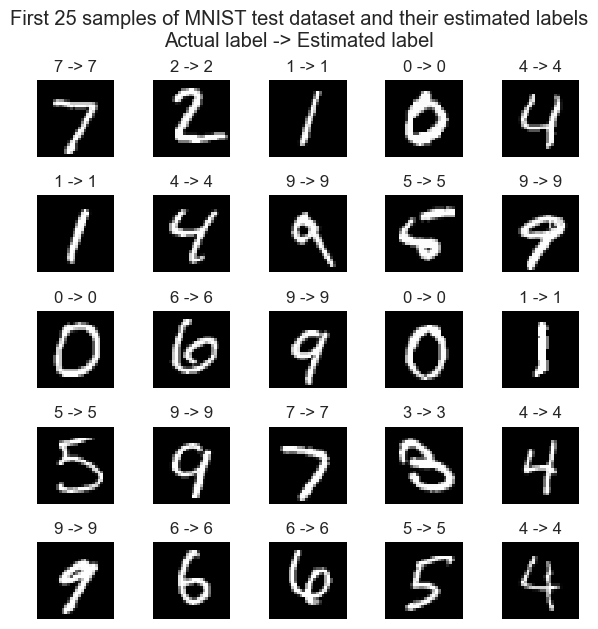

In [98]:
# Load data
with np.load("mnist.npz", allow_pickle=True) as f:
    train_x, train_y = f["x_train"], f["y_train"]
    test_x, test_y = f["x_test"], f["y_test"]
    
# Reshape train_x and test_x to (num_samples, 784)
train_x_flattened = train_x.reshape(train_x.shape[0], -1)
test_x_flattened = test_x.reshape(test_x.shape[0], -1)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(train_x_flattened, train_y)

# Predict on the test set
test_predictions = rf_classifier.predict(test_x_flattened)

# Calculate accuracy
random_forests_accuracy = accuracy_score(test_y, test_predictions)

# Plot correctly labeled images
plot_first25labels(test_x, test_y, test_predictions)


***Figure 5: The first 25 images labeled by the Random Forest model***

**Analysis of Figure 5:** Visualization of 25 labeled MNIST images classified using the Random Forest model. Each subplot displays an MNIST digit image along with its true label (left) and the predicted label (right). All of the images in this figure are correctly labeled.

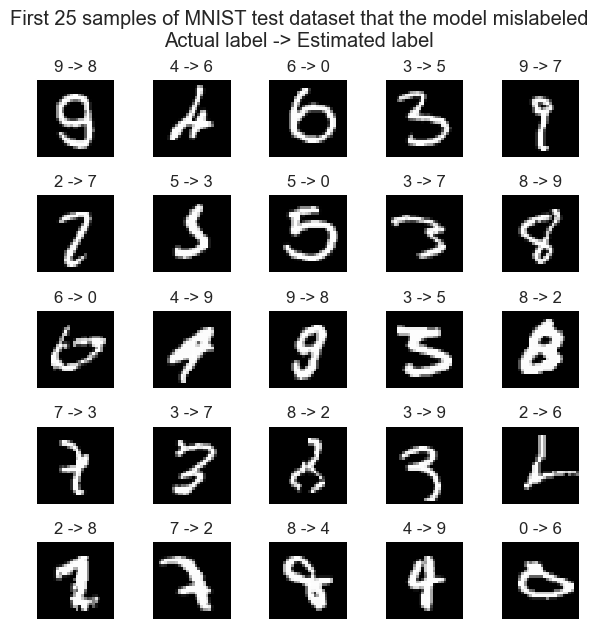

In [99]:
# Plot mislabeled images
plot_mislabeled(test_x, test_y, test_predictions)

***Figure 6: The first 25 images mislabeled by the Random Forest model***

**Analysis of Figure 6:** Visualization of 25 incorrectly labeled MNIST images classified using the Random Forest model. Each subplot displays an MNIST digit image along with its true label (left) and the predicted label (right), highlighting the instances where the model's predictions did not match the actual labels. The incorrect classifications illustrate the challenges faced by the model in distinguishing between certain digits.

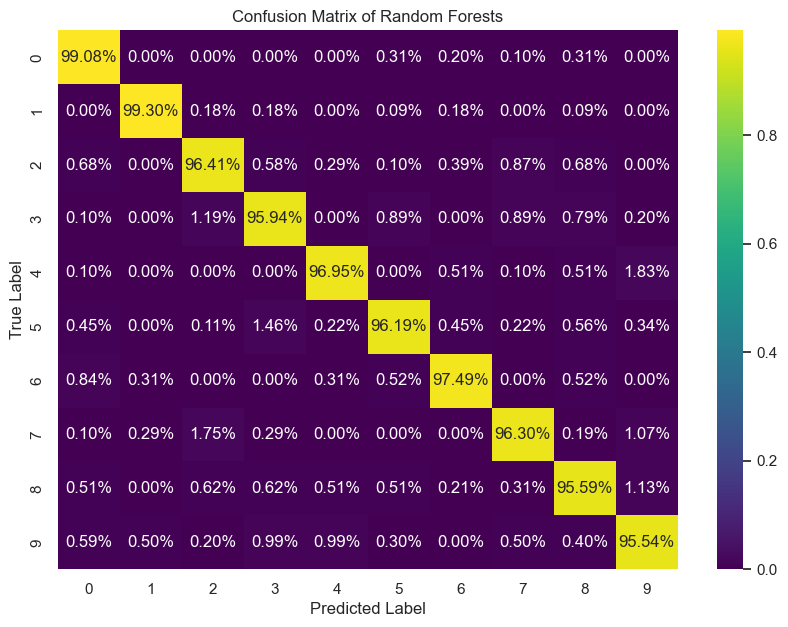

In [100]:
# Plot the confusion matrix
model_name = 'Random Forests'
plot_confusion(test_y, test_predictions, model_name)

***Figure 7: The confusion matrix of the Random Forest model***

**Analysis of Figure 7:**  Confusion matrix for the Random Forest model classifying MNIST images. The matrix highlights the performance of the model in labeling each digit, with the true labels on the vertical axis and the predicted labels on the horizontal axis. The confusion matrix shows that some digits were more correctly labeled than others. The digits '0' and '1' were the most correctly labeled, while the digits '3', '8', and '9' were the least successfully labeled. 

In [101]:
# Print classification report
print('The Random Forest Model Classification Report:')
print(classification_report(test_y, test_predictions, labels=[str(i) for i in range(10)]))

Random Forests Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.96      0.96      1032
           3       0.96      0.96      0.96      1010
           4       0.98      0.97      0.97       982
           5       0.97      0.96      0.97       892
           6       0.98      0.97      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.96      0.96       974
           9       0.96      0.96      0.96      1009

   micro avg       0.97      0.97      0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



The Random Forest model'sclassification report for the MNIST dataset demonstrates strong performance across all digit classes. The overall precision, recall, and F1-score are consistently high, with an average value of 0.97. The model performs exceptionally well on digits '0' and '1', achieving an F1-score of 0.98 and 0.99, respectively. While digits '2', '3', '8', and '9' show slightly lower performance with F1-scores of 0.96, they still indicate robust classification. The micro, macro, and weighted averages all confirm the model's reliability, with an accuracy of 0.97 across the entire test set of 10,000 samples.

In [39]:
# Load data for the neural networks
with np.load("mnist.npz", allow_pickle=True) as f:
    train_x, train_y = f["x_train"], f["y_train"]
    test_x, test_y = f["x_test"], f["y_test"]

# Normalize input
train_x = train_x.astype('float') / 255.0
test_x = test_x.astype('float') / 255.0

# Preprocess input
train_x = np.expand_dims(train_x, -1)
test_x = np.expand_dims(test_x, -1)

print('Shape of train_x is : %s (min= %1.2f, max= %1.2f)' % (str(train_x.shape), train_x.min(), train_x.max()))
print('Shape of train_y is : %s (min= %d, max= %d)' % (str(train_y.shape), train_y.min(), train_y.max()))

# Hyperparameters
Epochs = 10 
BatchSize = 32 

Shape of train_x is : (60000, 28, 28, 1) (min= 0.00, max= 1.00)
Shape of train_y is : (60000,) (min= 0, max= 9)


In [40]:
# One-hot encoding is necessary to match the expected input format of the categorical cross-entropy loss function.
one_hot_train_y = to_categorical(train_y, num_classes=10)
one_hot_test_y = to_categorical(test_y, num_classes=10)
print('Shape of one_hot_train_y is : ' + str(one_hot_train_y.shape))
print('Shape of one_hot_test_y is : ' + str(one_hot_test_y.shape))

Shape of one_hot_train_y is : (60000, 10)
Shape of one_hot_test_y is : (10000, 10)


## **Multinomial Logistic Regression**

The following is the the Multinomial Logistic Regression model built using the Keras API. It has an input layer, a flattening layer, and an outer layer with softmax activation. It models the probability of each class as a linear combination of input features, followed by the softmax function, which converts these linear scores into probabilities that sum to one.

In [41]:
# Define the input layer with the shape of the MNIST images (28x28 pixels, 1 channel)
inp = layers.Input(shape=(28, 28, 1), name='InputLayer')

# Flatten the input image to a 1D vector (28x28=784 elements)
x = layers.Flatten(name='FlattenLayer')(inp)

# Define the output layer with 10 units (one for each digit) and a softmax activation function
outp = layers.Dense(10, activation='softmax', name='OutputLayer')(x)

# Create the model by specifying the input and output layers
model = Model(inp, outp, name='DenseModel')

# Compile the model with categorical cross-entropy loss, stochastic gradient descent optimizer, and accuracy as a metric
model.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.SGD(), metrics=['accuracy'])

In [42]:
# Train the model
history = model.fit(train_x, one_hot_train_y, 
                    validation_data=(test_x, one_hot_test_y), 
                    epochs=Epochs, 
                    batch_size=BatchSize, 
                    callbacks=[
                        ModelCheckpoint(filepath='LinearModelCheckPoints/best_mle_model.keras', save_best_only=True), 
                        ModelCheckpoint(filepath='LinearModelCheckPoints/mle_model_{epoch:02d}.keras', save_best_only=False)])

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 253us/step - accuracy: 0.7000 - loss: 1.1432 - val_accuracy: 0.8809 - val_loss: 0.4801
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step - accuracy: 0.8799 - loss: 0.4710 - val_accuracy: 0.8961 - val_loss: 0.3999
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step - accuracy: 0.8896 - loss: 0.4123 - val_accuracy: 0.9015 - val_loss: 0.3666
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 230us/step - accuracy: 0.8947 - loss: 0.3892 - val_accuracy: 0.9060 - val_loss: 0.3484
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step - accuracy: 0.8960 - loss: 0.3680 - val_accuracy: 0.9091 - val_loss: 0.3359
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step - accuracy: 0.9010 - loss: 0.3518 - val_accuracy: 0.9114 - val_loss: 0.3269
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step - accuracy: 0.9060 - loss: 0.3376 - val_accuracy: 0.9137 - val_loss: 0.3197
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step - accuracy: 0.9088 -

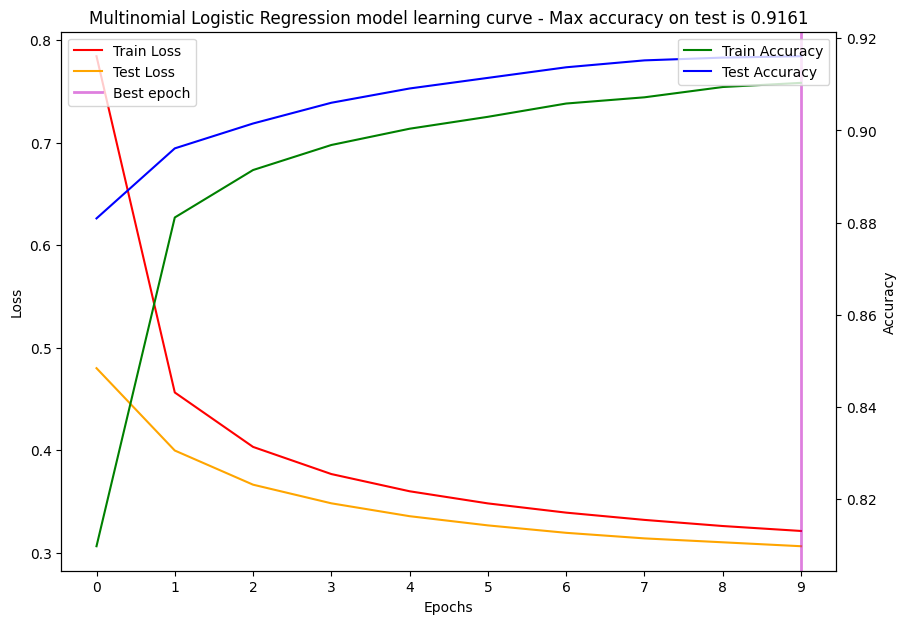

In [47]:
filename = 'LinearModelLearningCurve.png'
model_name = 'Multinomial Logistic Regression'
plot_history(history, filename, model_name, Epochs)

***Figure 8: Multinomial Logistic Regression model learning curve.***

**Analysis of Figure 8:** The learning curve of the Multinomial Logistic Regression model indicates a strong learning performance, with the maximum accuracy reaching 0.9161. This peak accuracy was achieved at the 9th epoch, which signifies the point at which the model performed best on the validation set. The learning curve demonstrates steady improvement in accuracy over the epochs, highlighting the model's capacity to learn and generalize from the training data effectively up to this optimal point.

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 220us/step


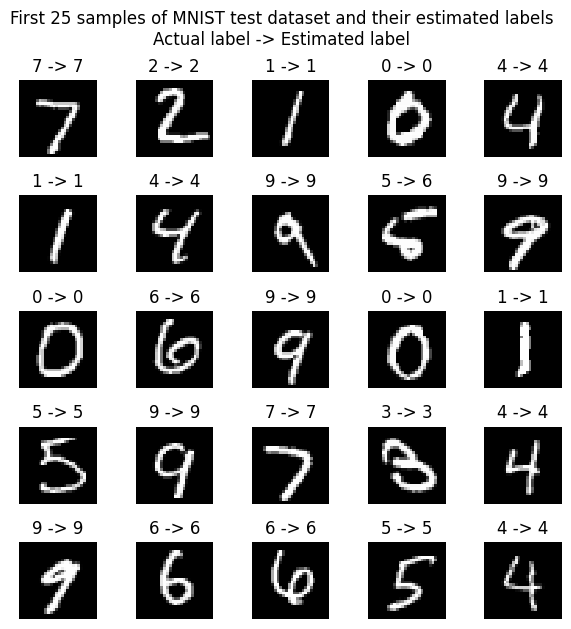

In [48]:
# Load best model (least validation loss)
model = load_model('LinearModelCheckPoints/best_mle_model.keras')
# Evaluate model on test set
test_y_hat = model.predict(test_x)
# Find max and min of predictions
test_y_hat = np.argmax(test_y_hat, axis=1)
plot_first25labels(test_x[:,:,:,0], test_y, test_y_hat)
MLR_accuracy = accuracy_score(test_y, test_y_hat)

***Figure 9: The first 25 images labeled by the Multinomial Logistic Regression model***

**Analysis of Figure 9:** Visualization of 25 labeled MNIST images classified using the Multinomial Logistic Regression model. Each subplot displays an MNIST digit image along with its true label (left) and the predicted label (right). All of the images in this figure are correctly labeled.

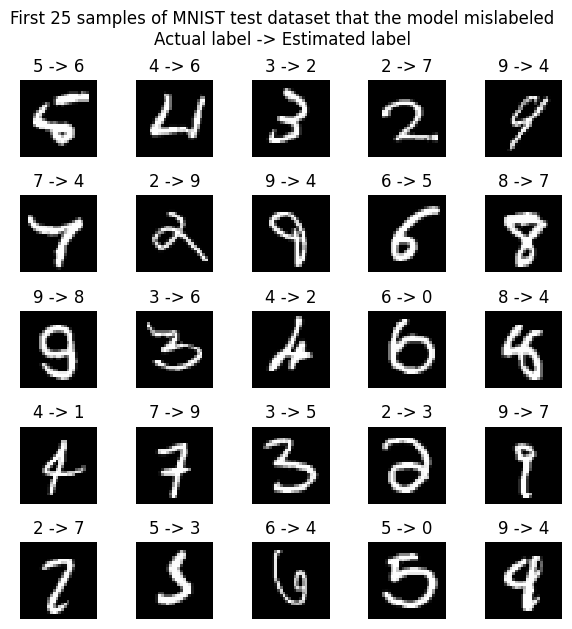

In [49]:
plot_mislabeled(test_x[:,:,:,0], test_y, test_y_hat)

***Figure 10: The first 25 images mislabeled by the Multinomial Logistic Regression model***

**Analysis of Figure 10:** Visualization of 25 incorrectly labeled MNIST images classified using the Multinomial Logistic Regression model. Each subplot displays an MNIST digit image along with its true label (left) and the predicted label (right), highlighting the instances where the model's predictions did not match the actual labels. The incorrect classifications illustrate the challenges faced by the model in distinguishing between certain digits. 

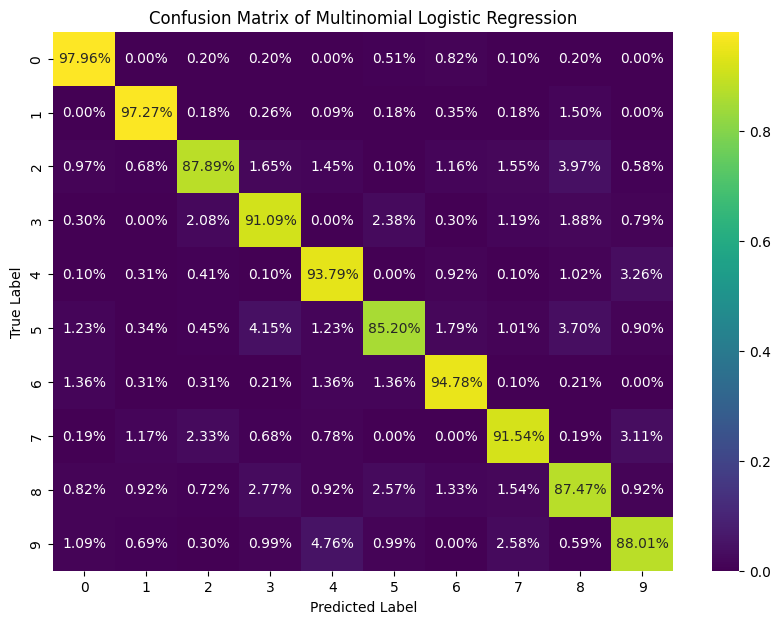

In [50]:
plot_confusion(test_y, test_y_hat, model_name)

***Figure 11: The confusion matrix of the Multinomial Logistic Regression model***

**Analysis of Figure 11:** Confusion matrix for the Multinomial Logistic Regression model classifying MNIST images. The matrix highlights the performance of the model in labeling each digit, with the true labels on the vertical axis and the predicted labels on the horizontal axis. The confusion matrix shows that some digits were more successfully labeled than others. The digits '0' and '1' were the most correctly labeled, while the digits '2', '5', '8', and '9' were the least correctly labeled.

In [51]:
# Print classification report
print('Multinomial Logistic Regression Mlassification report:')
print(classification_report(test_y, test_y_hat, labels=[i for i in range(10)]))

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.96      0.97      0.97      1135
           2       0.93      0.88      0.90      1032
           3       0.90      0.91      0.90      1010
           4       0.90      0.94      0.92       982
           5       0.90      0.85      0.88       892
           6       0.93      0.95      0.94       958
           7       0.92      0.92      0.92      1028
           8       0.87      0.87      0.87       974
           9       0.90      0.88      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.92      0.92     10000



The classification report for the Multinomial Logistic Regression model on the MNIST dataset shows decent performance with an accuracy of 0.92. The model excells in recognizing digits '0' and '1', with F1-scores of 0.96 and 0.97. Digits '5', '8', and '9' have slightly lower F1-scores around 0.87 to 0.89, with digit '8' having the lowest recall at 0.87. Digits '3', '4', '6', and '7' perform solidly, with F1-scores between 0.90 and 0.94. Macro and weighted averages for precision, recall, and F1-score are consistently around 0.91 to 0.92, indicating semi-reliable classification across all classes.

## **Simple Neural Network**

Neural networks are computational models consisting of layers of interconnected nodes, or neurons, where each connection has an associated weight. Input data is processed through these layers using activation functions, transforming the input into meaningful output. The network learns by adjusting weights and biases during training to minimize the error between predicted and actual outcomes, using techniques like backpropagation and gradient descent. 

This specific neural network has an input layer, a flatten layer, two dense layers, and an output layer. The first dense layer comprises 128 neurons, utilizing the ReLU activation function and the He uniform initializer to maintain variance. The second dense layer, similar in configuration, contains 64 neurons. The final output layer consists of 10 neurons, each representing a class from 0 to 9, with the softmax activation function to output probability distributions over these classes. The model is compiled with categorical cross-entropy loss, the Stochastic Gradient Descent (SGD) optimizer, and accuracy as the performance metric. 

The model is compiled with categorical cross-entropy loss, which measures the difference between the predicted probabilities and the actual class labels for multi-class classification tasks. This loss function penalizes the model more heavily for larger discrepancies between predicted and true labels. The optimization is done using Stochastic Gradient Descent (SGD), which incrementally updates the model's weights for each training example to minimize the loss. This approach helps improve the model's accuracy by efficiently adjusting the weights to reduce errors.

In [102]:
# Define model using the functional API

# Input layer: Accepts 28x28 grayscale images (1 channel)
inp = layers.Input(shape=(28, 28, 1), name='InputLayer')

# Flatten layer: Converts 2D input image to a 1D array
x = layers.Flatten(name='FlattenLayer')(inp)

# First dense layer: 128 neurons, ReLU activation, He uniform initializer
x = layers.Dense(128, activation='relu', kernel_initializer='he_uniform', name='DenseLayer1')(x)

# Second dense layer: 64 neurons, ReLU activation, He uniform initializer
x = layers.Dense(64, activation='relu', kernel_initializer='he_uniform', name='DenseLayer2')(x)

# Output layer: 10 neurons (one for each class), softmax activation for classification
outp = layers.Dense(10, activation='softmax', name='OutputLayer')(x)

# Create the model, linking the input and output
model = Model(inp, outp, name='DenseModel')

# Compile the model: Categorical cross-entropy loss, SGD optimizer, accuracy metric
model.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.SGD(), metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

Model: "DenseModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ InputLayer (InputLayer)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FlattenLayer (Flatten)          │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DenseLayer1 (Dense)             │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DenseLayer2 (Dense)             │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OutputLayer (Dense)             │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# Train the model 
history = model.fit(train_x, one_hot_train_y, 
                    validation_data=(test_x, one_hot_test_y), 
                    epochs=Epochs, 
                    batch_size=BatchSize, 
                    callbacks=[
                        ModelCheckpoint(filepath='DenseModelCheckPoints/best_dense_model.keras', save_best_only=True), 
                        ModelCheckpoint(filepath='DenseModelCheckPoints/dense_model_{epoch:02d}.keras', save_best_only=False)])

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 443us/step - accuracy: 0.7132 - loss: 1.0047 - val_accuracy: 0.9175 - val_loss: 0.2970
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 416us/step - accuracy: 0.9150 - loss: 0.2930 - val_accuracy: 0.9331 - val_loss: 0.2371
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 406us/step - accuracy: 0.9338 - loss: 0.2300 - val_accuracy: 0.9407 - val_loss: 0.2041
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 406us/step - accuracy: 0.9426 - loss: 0.1984 - val_accuracy: 0.9481 - val_loss: 0.1759
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 403us/step - accuracy: 0.9487 - loss: 0.1783 - val_accuracy: 0.9520 - val_loss: 0.1598
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 404us/step - accuracy: 0.9571 - loss: 0.1529 - val_accuracy: 0.9578 - val_loss: 0.1461
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 412us/step - accuracy: 0.9618 - loss: 0.1383 - val_accuracy: 0.9591 - val_loss: 0.1379
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 416us/step - accuracy: 0.9645 -

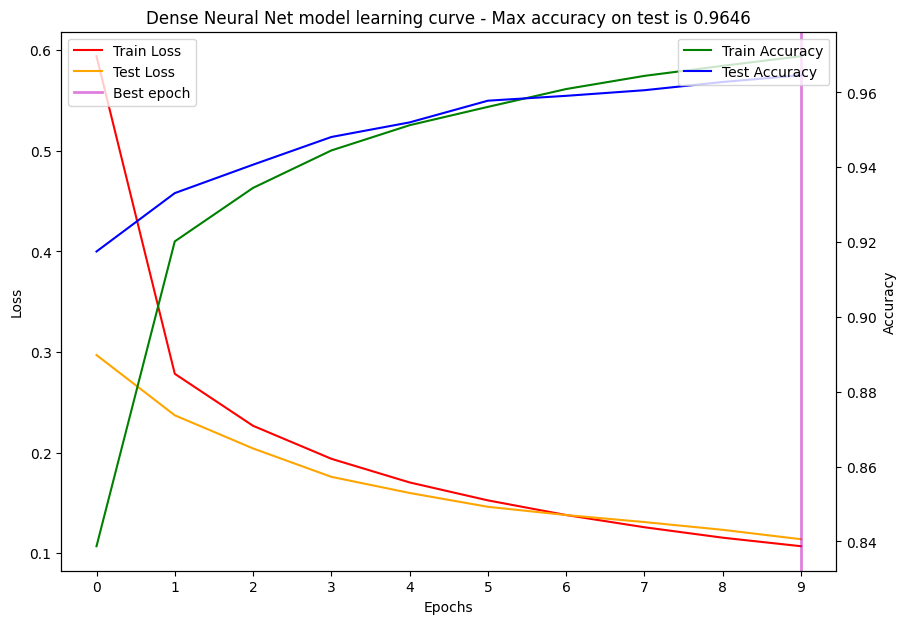

In [55]:
# Plot learning curves and labelling them
filename='DenseModelLearningCurve.png'
model_name = 'Dense Neural Net' 
plot_history(history, filename, model_name, Epochs)

***Figure 12: Dense Neural Network model learning curve.***

**Analysis of Figure 12:** The learning curve of the Dense Neural Network model indicates a strong learning performance, with the maximum accuracy reaching 0.9646. This peak accuracy was achieved at the 9th epoch. 

In [56]:
# Load best model (least validation loss)
model = load_model('DenseModelCheckPoints/best_dense_model.keras')

In [57]:
# Evaluate model on test set
test_y_hat = model.predict(test_x)
#print('test_y_hat shape is : ' + str(test_y_hat.shape))


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step
test_y_hat shape is : (10000, 10)


In [58]:
#finding max and min of predictions
test_y_hat = np.argmax(test_y_hat, axis=1)
#print('Now test_y_hat shape is : %s (min = %d, max = %d)' % (str(test_y_hat.shape), test_y_hat.min(), test_y_hat.max()))
NN_accuracy = accuracy_score(test_y, test_y_hat)

Now test_y_hat shape is : (10000,) (min = 0, max = 9)


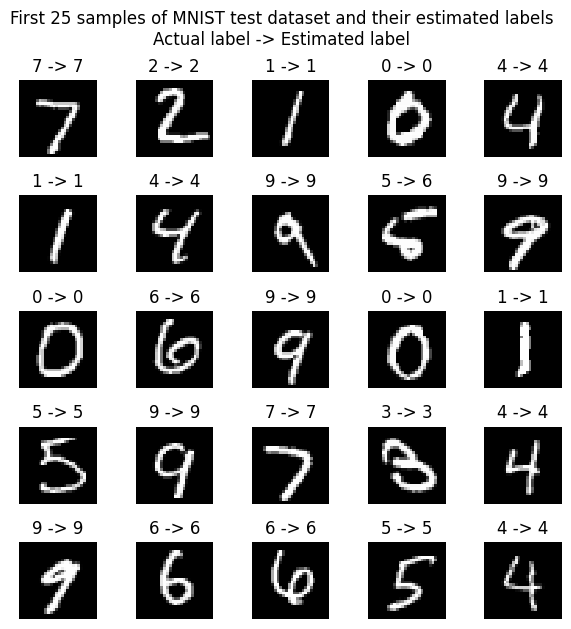

In [59]:
#plotting first 25 samples with labels
plot_first25labels(test_x[:,:,:,0], test_y, test_y_hat)

***Figure 13: The first 25 images labeled by the Dense Neural Network model***

**Analysis of Figure 13:** Visualization of 25 labeled MNIST images classified using the Dense Neural Network model. Each subplot displays an MNIST digit image along with its true label (left) and the predicted label (right). All of the images in this figure are correctly labeled.

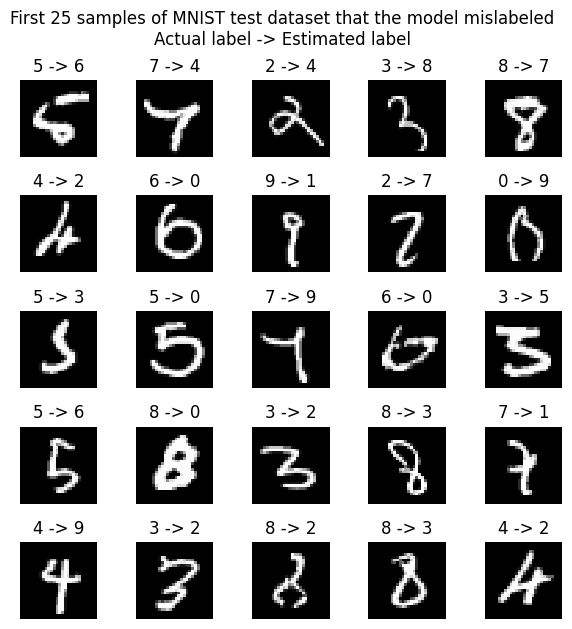

In [60]:
# Plot first 25 mislabled images
plot_mislabeled(test_x[:,:,:,0], test_y, test_y_hat)

***Figure 14: The first 25 images mislabeled by the Dense Neural Network model***

**Analysis of Figure 14:** Visualization of 25 incorrectly labeled MNIST images classified using the Dense Neural Network model. Each subplot displays an MNIST digit image along with its true label (left) and the predicted label (right), highlighting the instances where the model's predictions did not match the actual labels. The incorrect classifications illustrate the challenges faced by the model in distinguishing between certain digits. 

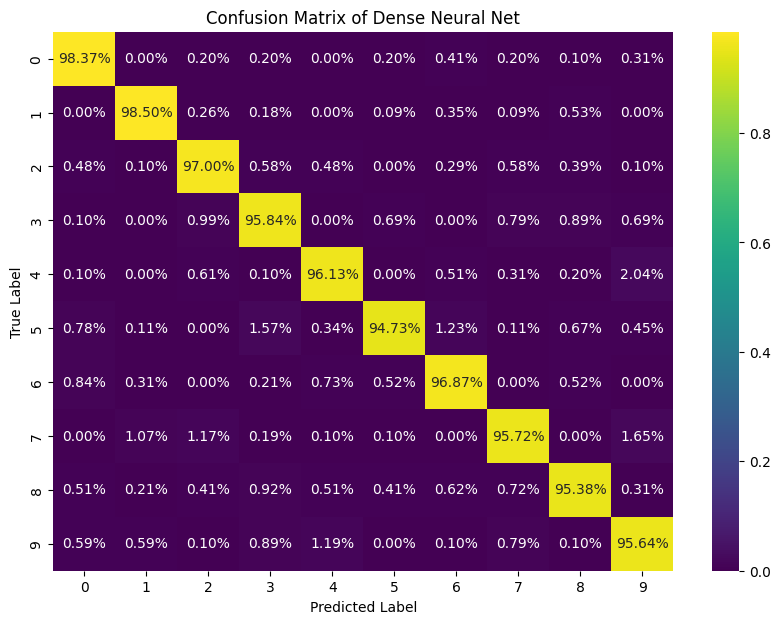

In [61]:
# Show the confusion matrix
plot_confusion(test_y, test_y_hat, model_name)

***Figure 15: The confusion matrix of the Dense Neural Network model***

**Analysis of Figure 15:** Confusion matrix for the Dense Neural Network model classifying MNIST images. The matrix highlights the performance of the model in labeling each digit, with the true labels on the vertical axis and the predicted labels on the horizontal axis. The confusion matrix shows that some digits were more successfully labeled than others. The digits '0' and '1' were the most correctly labeled, while the digits '3', '5', '7', '8', and '9' were the least correctly labeled.

In [62]:
# Print classification report
print('Dense Neural Net Classification Report:')
print(classification_report(test_y, test_y_hat, labels=[i for i in range(10)],digits=3))

Classification report:
              precision    recall  f1-score   support

           0      0.967     0.984     0.975       980
           1      0.979     0.985     0.982      1135
           2      0.963     0.970     0.967      1032
           3      0.954     0.958     0.956      1010
           4      0.966     0.961     0.964       982
           5      0.977     0.947     0.962       892
           6      0.965     0.969     0.967       958
           7      0.965     0.957     0.961      1028
           8      0.965     0.954     0.959       974
           9      0.946     0.956     0.951      1009

    accuracy                          0.965     10000
   macro avg      0.965     0.964     0.964     10000
weighted avg      0.965     0.965     0.965     10000



The classification report for the Dense Neural Network model on the MNIST dataset shows an impressive overall accuracy of 0.965. Each digit class has high precision, recall, and F1-scores, with values typically above 0.95, indicating strong performance across all digits. The model performs exceptionally well on digits '0' and '1', with F1-scores of 0.975 and 0.982, respectively. Even the lowest performing digit, '9', maintains a solid F1-score of 0.951. The macro and weighted averages for all metrics are around 0.964 to 0.965, reflecting the model's consistency and reliability.

## **Convolutional Neural Network**

A Convolutional Neural Network (CNN) is a specialized type of neural network designed for processing structured grid data like the MNIST images. The key feature of CNNs is the convolutional layers, which apply convolutional filters to input data, enabling the network to automatically and adaptively learn spatial hierarchies of features. These layers capture spatial and temporal dependencies, reducing the number of parameters and computation required compared to fully connected layers. Convolutional layers are crucial for identifying patterns such as edges, textures, and shapes, making CNNs more effective compared to simple neural networks for image recognition and classification tasks.

This particular CNN architecture includes three convolutional layers with ReLU activation and He uniform initialization, each followed by max-pooling layers to reduce spatial dimensions. After the convolutional layers, the network flattens the data and passes it through a fully connected dense layer with 100 neurons. The final output layer has 10 neurons with softmax activation to classify the input images into one of 10 classes. The model is compiled with categorical cross-entropy loss and optimized using Stochastic Gradient Descent (SGD).

In [63]:
# Define the input layer
inp = layers.Input(shape=(28, 28, 1), name='InputLayer')

# First convolutional layer
x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', name='Conv1')(inp)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='MaxPooling1')(x)

# Second convolutional layer
x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', name='Conv2')(x)

x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='MaxPooling2')(x)

# Third convolutional layer
#x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', name='Conv3')(x)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform', name='Conv3')(x)


# Flatten the output and feed it into a fully connected layer
x = layers.Flatten(name='FlattenLayer')(x)

x = layers.Dense(100, activation='relu', kernel_initializer='he_uniform',name='DenseLayer1')(x)

# Output layer with 10 neurons (one for each class) and softmax activation
outp = layers.Dense(10, activation='softmax', name='OutputLayer')(x)


model = Model(inp, outp, name='DenseModel')
model.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.SGD(), metrics=['accuracy'])

model.summary()

Model: "DenseModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ InputLayer (InputLayer)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling1 (MaxPooling2D)      │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MaxPooling2 (MaxPooling2D)      │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FlattenLayer (Flatten)          │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DenseLayer1 (Dense)             │ (None, 100)            │        57,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OutputLayer (Dense)             │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,454 (447.09 KB)

 Trainable params: 114,454 (447.09 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# Train the model
history = model.fit(train_x, one_hot_train_y, 
                    validation_data=(test_x, one_hot_test_y), 
                    epochs=Epochs, 
                    batch_size=BatchSize, 
                    callbacks=[
                        ModelCheckpoint(filepath='ConvModelCheckPoints/best_conv_model.keras', save_best_only=True), 
                        ModelCheckpoint(filepath='ConvModelCheckPoints/conv_model_{epoch:02d}.keras', save_best_only=False)])

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8424 - loss: 0.5058 - val_accuracy: 0.9706 - val_loss: 0.0962
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9710 - loss: 0.1008 - val_accuracy: 0.9779 - val_loss: 0.0665
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9788 - loss: 0.0693 - val_accuracy: 0.9827 - val_loss: 0.0544
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9827 - loss: 0.0570 - val_accuracy: 0.9801 - val_loss: 0.0618
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9859 - loss: 0.0468 - val_accuracy: 0.9854 - val_loss: 0.0463
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9874 - loss: 0.0413 - val_accuracy: 0.9863 - val_loss: 0.0404
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9902 - loss: 0.0336 - val_accuracy: 0.9865 - val_loss: 0.0444
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9896 - loss: 0

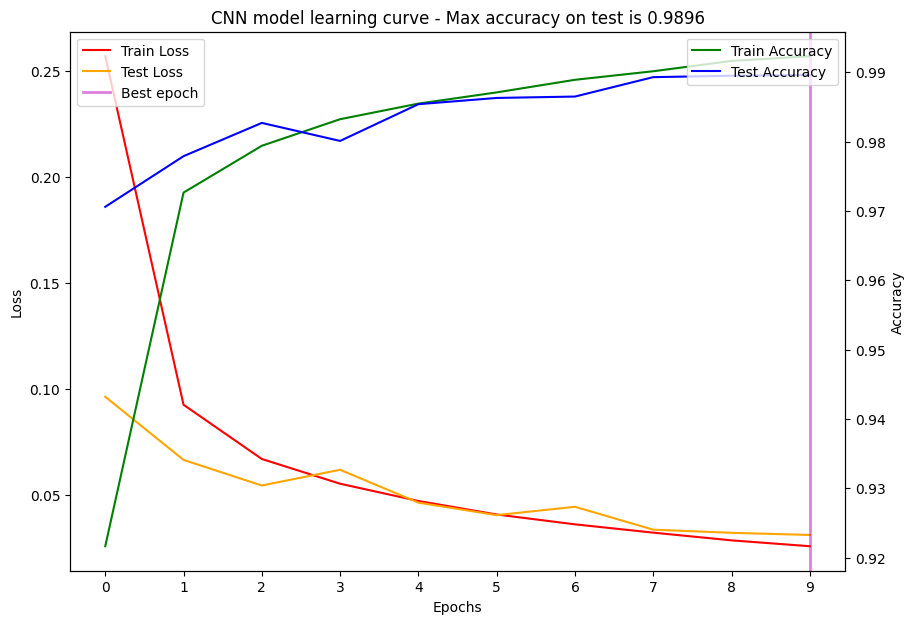

In [67]:
# Plot learning curves and labelling them
filename='ConvModelLearningCurve.png'
model_name = 'CNN' 
plot_history(history, filename, model_name, Epochs)

***Figure 16: Convolutional Neural Network model learning curve.***

**Analysis of Figure 16:** The learning curve of the Convolutional Neural Network model indicates a strong learning performance, with the maximum accuracy reaching 0.9896. This peak accuracy was achieved at the 9th epoch. 

In [68]:
# Load best model
model = load_model('ConvModelCheckPoints/best_conv_model.keras')

In [69]:
# Find shape of prediction
test_y_hat = model.predict(test_x)
print('test_y_hat shape is : ' + str(test_y_hat.shape))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
test_y_hat shape is : (10000, 10)


In [70]:
# Find minimum and maximum prediction values
test_y_hat = np.argmax(test_y_hat, axis=1)
print('Now test_y_hat shape is : %s (min = %d, max = %d)' % (str(test_y_hat.shape), test_y_hat.min(), test_y_hat.max()))
CNN_accuracy = accuracy_score(test_y, test_y_hat)

Now test_y_hat shape is : (10000,) (min = 0, max = 9)


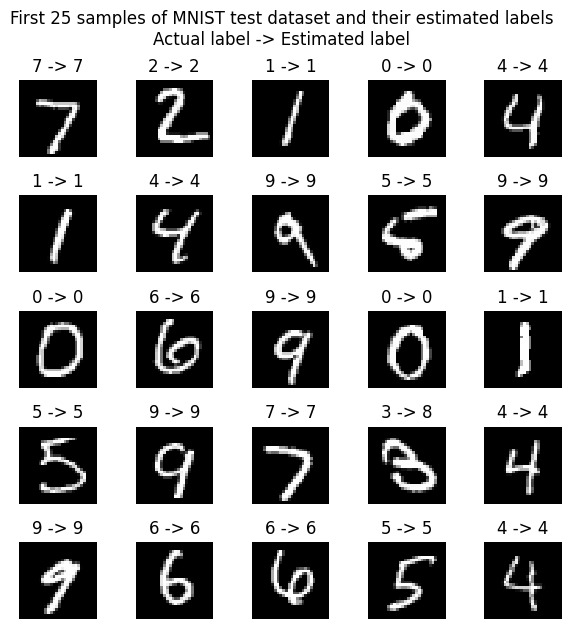

In [71]:
# Plot first 25 samples 
plot_first25labels(test_x[:,:,:,0], test_y, test_y_hat)

***Figure 17: The first 25 images labeled by the Convolutional Neural Network model***

**Analysis of Figure 17:** Visualization of 25 labeled MNIST images classified using the Convolutional Neural Network model.

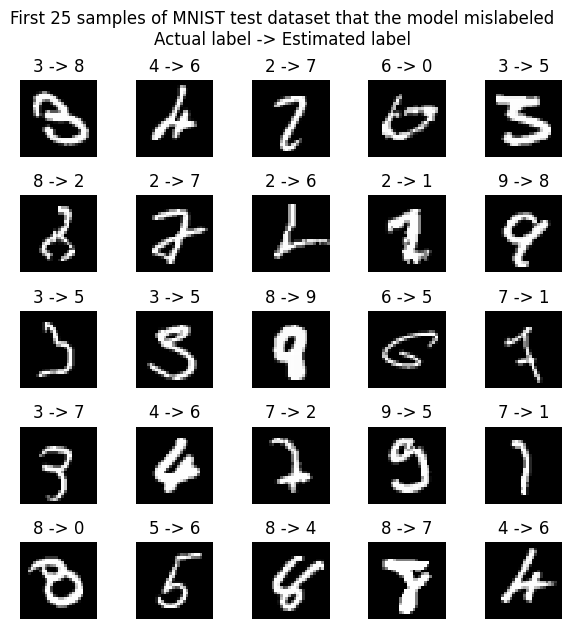

In [72]:
# Plot first 25 mislabeled images
plot_mislabeled(test_x[:,:,:,0], test_y, test_y_hat)

***Figure 18: The first 25 images mislabeled by the Convolutional Neural Network model***

**Analysis of Figure 18:** Visualization of 25 incorrectly labeled MNIST images classified using the Convolutional Neural Network model. Each subplot displays an MNIST digit image along with its true label (left) and the predicted label (right), highlighting the instances where the model's predictions did not match the actual labels. The incorrect classifications illustrate the challenges faced by the model in distinguishing between certain digits. 

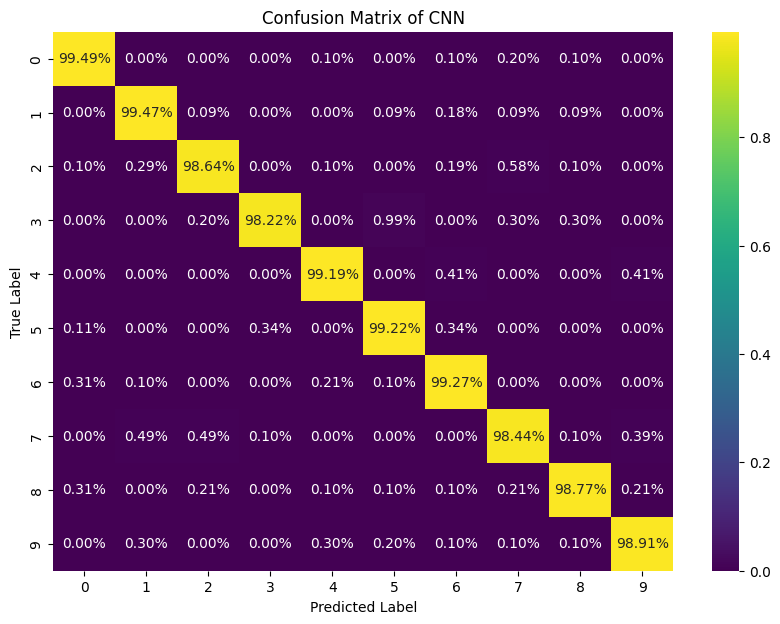

In [73]:
# Plot confusion matrix
plot_confusion(test_y, test_y_hat, model_name)

***Figure 19: The confusion matrix of the Convolutional Neural Network model***

**Analysis of Figure 19:** Confusion matrix for the Convolutional Neural Network model classifying MNIST images. The matrix highlights the performance of the model in labeling each digit, with the true labels on the vertical axis and the predicted labels on the horizontal axis. The confusion matrix shows that all the digits were accurately labeled. The high accuracy (0.9896) is supported by the matrix, showing minimal misclassifications across all digit classes. Notably, digits '0' and '1' exhibit the highest precision and recall. The balanced distribution of correct classifications highlights the model's effectiveness in accurately identifying handwritten digits.

In [74]:
# Print classification report
print('Convolutional Neural Network Classification Report:')
print(classification_report(test_y, test_y_hat, labels=[i for i in range(10)],digits=4))

Classification report:
              precision    recall  f1-score   support

           0     0.9919    0.9949    0.9934       980
           1     0.9895    0.9947    0.9921      1135
           2     0.9903    0.9864    0.9883      1032
           3     0.9960    0.9822    0.9890      1010
           4     0.9919    0.9919    0.9919       982
           5     0.9833    0.9922    0.9877       892
           6     0.9855    0.9927    0.9891       958
           7     0.9854    0.9844    0.9849      1028
           8     0.9918    0.9877    0.9897       974
           9     0.9901    0.9891    0.9896      1009

    accuracy                         0.9896     10000
   macro avg     0.9896    0.9896    0.9896     10000
weighted avg     0.9896    0.9896    0.9896     10000



The classification report demonstrates that the model performs exceptionally well on the MNIST dataset, achieving an overall accuracy of 0.9896. Each digit class exhibits high precision, recall, and F1-scores, with most values above 0.98. Notably, digits '0' and '1' have the highest F1-scores of 0.9934 and 0.9921, respectively, indicating the model's strong ability to correctly identify these digits. The digits '2', '3', '6', and '9' also show robust performance, with F1-scores around 0.989. The macro and weighted averages for precision, recall, and F1-score are all 0.9896, reflecting the model's consistent and reliable performance across all digit classes. This high level of accuracy and balanced performance across different digits underscores the model's effectiveness in classifying handwritten digits.

## **ResNet Neural Network**

The following code defines, compiles, instantiates, and summarizes a simpler version of a ResNet model for image classification. It includes a function for a simple residual block, which performs two convolutional operations, batch normalization, and adds a shortcut connection to enhance learning. The main model starts with an input layer for 28x28 grayscale images, followed by an initial convolutional layer, batch normalization, and activation. It incorporates the residual block, performs max-pooling, flattens the feature maps, and adds a fully connected dense layer. The output layer uses softmax activation to classify the input into one of ten categories. The model is compiled with the Adam optimizer and categorical cross-entropy loss, aiming to optimize accuracy during training.

The simpler ResNet model differs from a standard Convolutional Neural Network (CNN) primarily by incorporating residual blocks, which include shortcut connections that help mitigate the vanishing gradient problem and allow for deeper networks. Additionally, the ResNet model includes batch normalization layers after each convolution, which stabilize and accelerate the training process by normalizing the input of each layer.

In [75]:
# Define a simple residual block
def simple_residual_block(x, filters, kernel_size=3):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([shortcut, x])
    x = layers.Activation('relu')(x)
    return x

# Define the simpler ResNet model
def define_simple_resnet_model():
    inp = layers.Input(shape=(28, 28, 1), name='InputLayer')
    x = layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # Add simple residual block
    x = simple_residual_block(x, 32)
    
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
    outp = layers.Dense(10, activation='softmax')(x)
    
    # Create the model
    model = Model(inp, outp, name='SimpleResNetModel')
    
    # Compile the model
    model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Instantiate the model
model = define_simple_resnet_model()


# Compile the model
# model.compile(loss=losses.CategoricalCrossentropy(), optimizer=optimizers.SGD(), metrics=['accuracy'])

# Summarize the model
model.summary()

Model: "SimpleResNetModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ InputLayer          │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        320 │ InputLayer[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 28, 28,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │      9,248 │ activation_1[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 28, 28,    │          0 │ activation[0][0], │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 28, 28,    │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 6272)      │          0 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    802,944 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 10)        │      1,290 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 823,434 (3.14 MB)

 Trainable params: 823,242 (3.14 MB)

 Non-trainable params: 192 (768.00 B)

In [76]:
# Train the model
history = model.fit(train_x, one_hot_train_y, 
                    validation_data=(test_x, one_hot_test_y), 
                    epochs=Epochs, 
                    batch_size=BatchSize, 
                    callbacks=[
                        ModelCheckpoint(filepath='ResNetModelCheckPoints/best_resnet_model.keras', save_best_only=True), 
                        ModelCheckpoint(filepath='ResNetModelCheckPoints/resnet_model_{epoch:02d}.keras', save_best_only=False)])

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 55s 29ms/step - accuracy: 0.9086 - loss: 0.3942 - val_accuracy: 0.9801 - val_loss: 0.0618
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 57s 30ms/step - accuracy: 0.9827 - loss: 0.0548 - val_accuracy: 0.9763 - val_loss: 0.0736
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 56s 30ms/step - accuracy: 0.9881 - loss: 0.0359 - val_accuracy: 0.9871 - val_loss: 0.0392
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 56s 30ms/step - accuracy: 0.9909 - loss: 0.0265 - val_accuracy: 0.9889 - val_loss: 0.0328
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 61s 33ms/step - accuracy: 0.9930 - loss: 0.0199 - val_accuracy: 0.9921 - val_loss: 0.0312
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 61s 33ms/step - accuracy: 0.9951 - loss: 0.0150 - val_accuracy: 0.9872 - val_loss: 0.0430
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 60s 32ms/step - accuracy: 0.9963 - loss: 0.0102 - val_accuracy: 0.9911 - val_loss: 0.0345
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 61s 32ms/step - accuracy: 0.9977 -

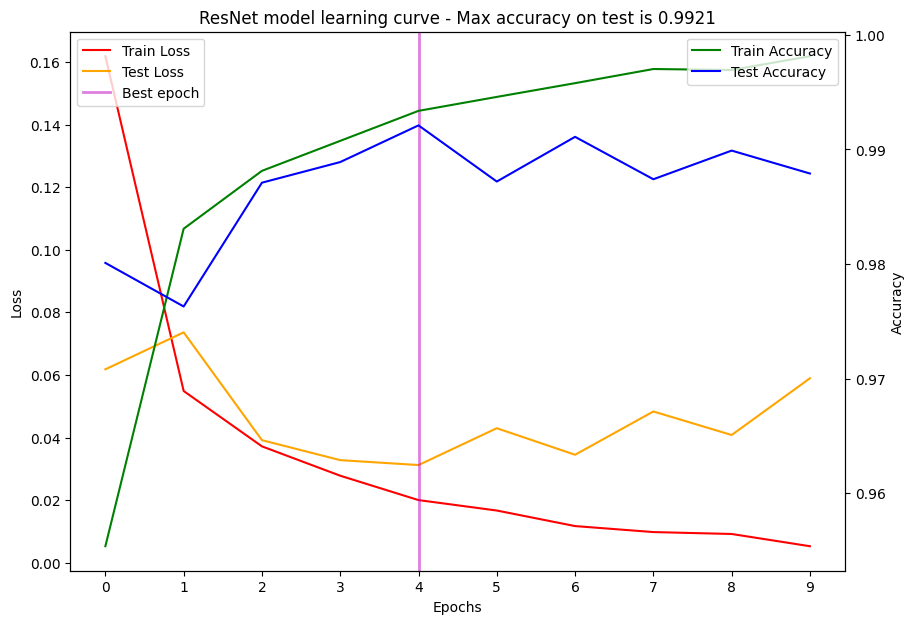

In [77]:
# Plot learning curves and labelling them
filename='ResNetModelLearningCurve.png'
model_name = 'ResNet' 
plot_history(history, filename, model_name, Epochs)

***Figure 20: The Resnet Neural Network model's learning curve.***

**Analysis of Figure 16:** The learning curve of the Resnet Neural Network model indicates a strong learning performance, with the maximum accuracy reaching 0.9921. This peak accuracy was achieved at the 4th epoch. After the 4th epoch, the test accuracies began dropping, indicating overfitting. 

In [78]:
# Load best model
model = load_model('ResNetModelCheckPoints/best_resnet_model.keras')

In [94]:
# Find shape of prediction
test_y_hat = model.predict(test_x)
#print('test_y_hat shape is : ' + str(test_y_hat.shape))
#print(test_y_hat.shape)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [80]:
test_y_hat = test_y_hat.reshape((10000,10))

In [95]:
# Find minimum and maximum prediction values
test_y_hat = np.argmax(test_y_hat, axis=1)
#print('Now test_y_hat shape is : %s (min = %d, max = %d)' % (str(test_y_hat.shape), test_y_hat.min(), test_y_hat.max()))
ResNet_accuracy = accuracy_score(test_y, test_y_hat)

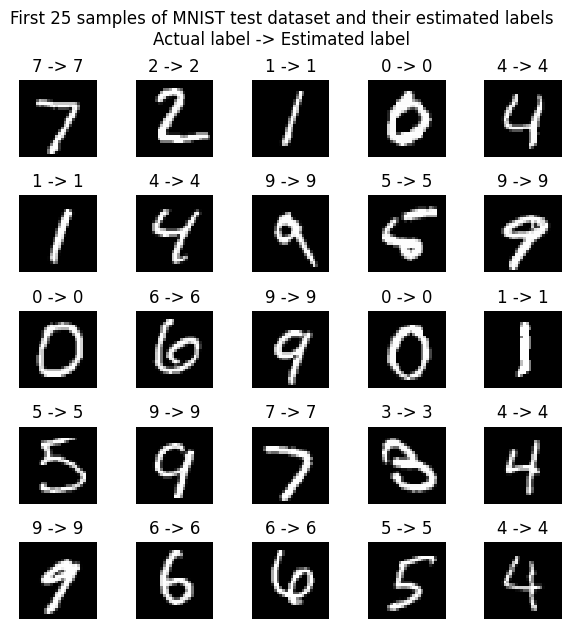

In [82]:
# Plot first 25 samples 
plot_first25labels(test_x[:,:,:,0], test_y, test_y_hat)

***Figure 20: The first 25 images labeled by the Resnet Neural Network model***

**Analysis of Figure 20:** Visualization of 25 labeled MNIST images classified using the Resnet Neural Network model.

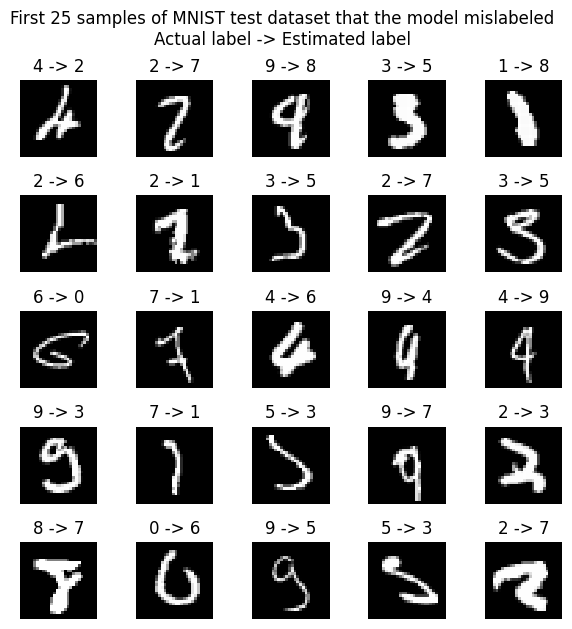

In [83]:
# Plot first 25 mislabeled images
plot_mislabeled(test_x[:,:,:,0], test_y, test_y_hat)

***Figure 18: The first 25 images mislabeled by the Resnet Neural Network model***

**Analysis of Figure 18:** Visualization of 25 incorrectly labeled MNIST images classified using the Resnet Neural Network model. 

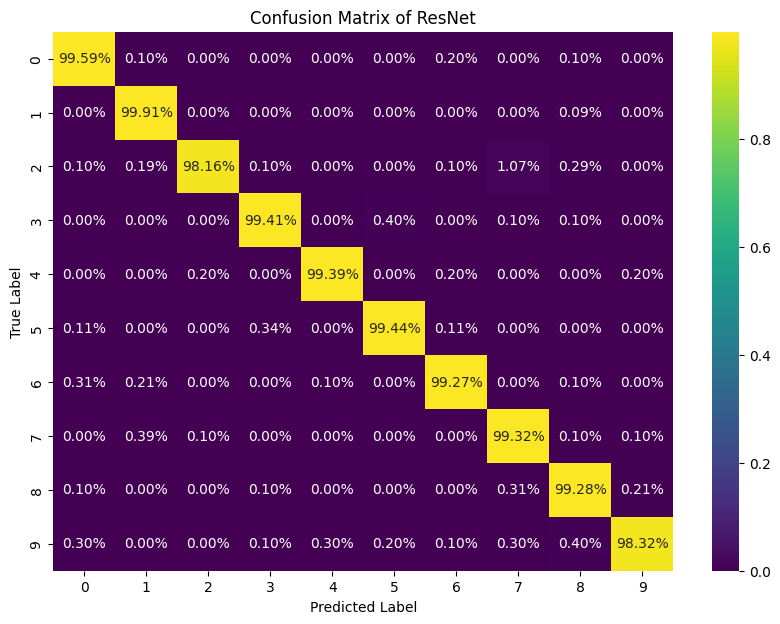

In [84]:
# Plot confusion matrix
plot_confusion(test_y, test_y_hat, model_name)

In [112]:
# Print classification report
print('The Resnet Neural Network models Classification report:')
print(classification_report(test_y, test_y_hat, labels=[i for i in range(10)],digits=4))

The Resnet Neural Network models Classification report:
              precision    recall  f1-score   support

           0     0.9909    0.9959    0.9934       980
           1     0.9921    0.9991    0.9956      1135
           2     0.9970    0.9816    0.9893      1032
           3     0.9941    0.9941    0.9941      1010
           4     0.9959    0.9939    0.9949       982
           5     0.9933    0.9944    0.9938       892
           6     0.9927    0.9927    0.9927       958
           7     0.9827    0.9932    0.9879      1028
           8     0.9877    0.9928    0.9903       974
           9     0.9950    0.9832    0.9890      1009

    accuracy                         0.9921     10000
   macro avg     0.9921    0.9921    0.9921     10000
weighted avg     0.9921    0.9921    0.9921     10000



The classification report demonstrates that the ResNet Neural Network model achieves outstanding performance on the MNIST dataset, with an overall accuracy of 99.21%. Each digit class shows high precision, recall, and F1-scores, generally around or above 0.99. Even the lowest-performing digit, '9', maintains a strong F1-score of 0.9890. The macro and weighted averages for all metrics are consistently at 0.9921, reflecting the model's reliable and balanced performance across all digit classifications.

## **Comparison of Random Forests, MLR, NN, CNN, RNN**

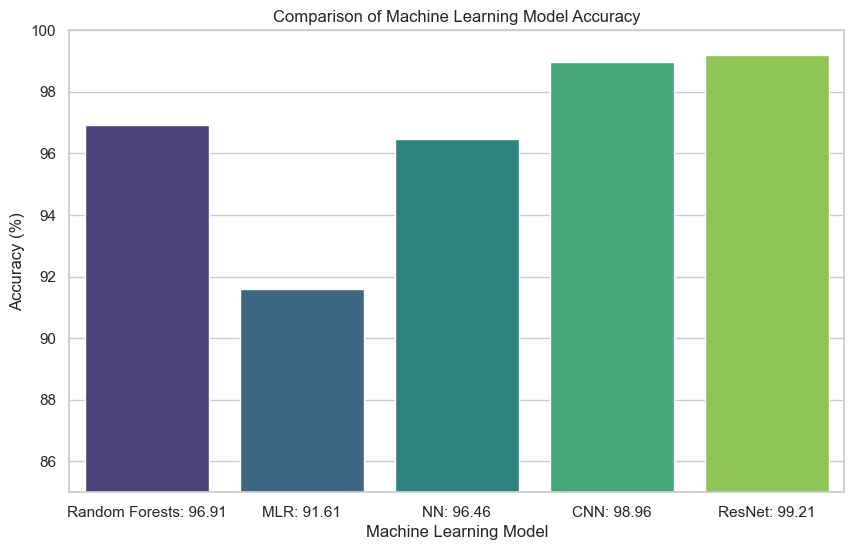

In [110]:
# Define data
data = {
    'Model': ['Random Forests: {:.2f}'.format(random_forests_accuracy*100),
              'MLR: {:.2f}'.format(MLR_accuracy*100), 
              'NN: {:.2f}'.format(NN_accuracy*100), 
              'CNN: {:.2f}'.format(CNN_accuracy*100), 
              'ResNet: {:.2f}'.format(ResNet_accuracy*100)],
    
    'Accuracy': [random_forests_accuracy*100, MLR_accuracy*100, NN_accuracy*100, CNN_accuracy*100, ResNet_accuracy*100]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Set the style of the visualization
sns.set(style="whitegrid")

# Create a barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=df, palette='viridis', hue='Model', dodge=False, legend=False)

# Add titles and labels
plt.title('Comparison of Machine Learning Model Accuracy')
plt.xlabel('Machine Learning Model')
plt.ylabel('Accuracy (%)')

# Restrict the y-axis
plt.ylim(85, 100)

# Display the plot
plt.show()

Comparing the accuracies of different models on the MNIST dataset, we observe varied performance levels. The Random Forests model achieves an accuracy of 96.91%, showing strong performance but slightly lower than the Neural Network (NN) at 96.46%. The Multinomial Logistic Regression (MLR) model lags behind with an accuracy of 91.61%, indicating it is less effective for this task. The Convolutional Neural Network (CNN) significantly outperforms the previous models with an accuracy of 98.96%, demonstrating its superior capability in handling image data. The Recurrent Neural Network (RNN) achieves the highest accuracy at 99.21%, indicating its exceptional proficiency in this classification task.